# Runge-Kutta methods and adaptive time-stepping

TMA4125 Vår 2022

This notebook accompanies the slides [06b-Runge-Kutta-methods-and-adaptivity.pdf](https://www.math.ntnu.no/emner/TMA4125/2022v/lecture-notes/06b-Runge-Kutta-methods-and-adaptivity.pdf).

In [1]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from numpy.linalg import norm

## Numerical implementation
Let's implement a routine to solve ODEs numerically through explicit Runge-Kutta methods

### Explicit Runge-Kutta methods
The routine below implements an explicit Runge-Kutta method based on its tableau:

In [2]:
def explicitRK(a, b, c, y0, T, f, h):
    """
        explicitRK(a, b, c, y0, T, f, h)
    
    Use an explicit Runge-Kutta method to approximate the solution of the ODE (scalar or system) y'(t) = f(t,y);
    -> An RK method requires first computing s stage derivatives k_i, i=1,...,s, given by
    k_i = f(t_n+c_i*h, y_{n} + h\sum_{j=1}^s a_ij*k_i)
    -> Then, we compute the next-step solution y_{n+1} via
    y_{n+1} = y_{n} + h\sum_{i=1}^s b_i*k_i
    
    Input:
        a  - s-by-s array containing the linear coefficients a_ij 
        b  - s-by-1 array containing the b_i linear coefficients 
        c  - s-by-1 array containing the c_i linear coefficients 
        y0 - initial value y(0)
        f  - definition of the right-hand-side function
        T  - simulation time (starting at t=0, ending at t=T)
        h  - time-step size (fixed)
    Output:
        ys  - array containing all discrete solution values y0,y1,y2,...
        ts  - array containing all discrete time instants 0,h,2h,...
    """
    s = len(b) #read number of stages (=length of b or c)
    ks = [np.zeros_like(y0, dtype=np.double) for s in range(s)] #array for stage derivatives k_i
    ys = [y0] #array where all y_n will be stored
    ts = [0] #array where all t_n will be stored
    while(ts[-1] < T):
        t, y = ts[-1], ys[-1]
        #Compute stage derivatives k_i
        for i in range(s):
            t_i = t + c[i]*h #compute time instant t_i used at stage i
            dY_i = np.zeros_like(y, dtype=np.double) 
            
            for j in range(i):
                dY_i += h*a[i,j]*ks[j] #accumulate the increments for stage i
                
            ks[i] = f(t_i, y + dY_i) #compute and store the stage derivative k_i
                
        # Compute next time-step
        dy = np.zeros_like(y, dtype=np.double) #accumulate the increments for y_{n+1}
        for i in range(s):
            dy += h*b[i]*ks[i]
            
        ys.append(y + dy)
        ts.append(t + h)
            
    return (np.array(ts), np.array(ys))

### Heun-Euler adaptive scheme
The routine below implements an adaptive time-stepping scheme combining Heun's and Euler's methods.

In [3]:
def HeunWithEuler(y0, T, f, h, tol, gamma, alpha):
    """
        HeunWithEuler(y0, T, f, h, tol, gamma, alpha)
    
    Use an adaptive Runge-Kutta scheme to approximate the solution of the ODE (scalar or system) y'(t) = f(t,y);
    This is an embedded scheme using Heun's and Euler's methods as higher- and lower-order methods, respectively.
  
    Input:
        y0    - initial value y(0)
        f     - definition of the right-hand-side function
        T     - simulation time (starting at t=0, ending at t=T)
        h     - "initial guess" for the time-step size
        tol   - tolerance for accepting/rejecting the solution computed after at a certain time step
        gamma - positive coefficient applied to the newly estimatated time-step size h. Usually taken as < 1
        alpha - coefficient (>1) used to increase the time-step size h after an accepted time step
    Output:
        y  - array containing all discrete solution values y0,y1,y2,...,yn
        t  - array containing all discrete time instants 0,h1,h1+h2,...,T
    """
    ys = [y0] #array where all y_n will be stored
    ts = [0]  #array where all t_n will be stored
    hs = [h]  #array where all time-step sizes h are stored
    while(ts[-1] < T):
        t, y = ts[-1], ys[-1]
        k1 = f(t,y) #compute first stage
        k2 = f(t+h, y+h*k1) #compute second stage
        epsilon = norm(h*((.5-1)*k1 + (.5-0)*k2)) #estimate the error based on the "Heun-Euler difference" 
        if epsilon <= tol: #accept this time step if the tolerance is met
            if t+h > T: #adjust the last time-step size h to finish exactly at the final time t = T
                h = T-t
            else:
                ys.append(y + 0.5*h*(k1+k2))
                ts.append(t + h)
                hs.append(h)
                h = alpha*h #increase the time-step size (multiplying h by a factor alpha > 1)
        else: #if the step is rejected, adapt the time-step size and re-do step 
            h = h*gamma*((tol/epsilon)**1/2) 
    
    return (np.array(ts), np.array(ys),  np.array(hs))

## Numerical example: the Riccati equation
We will now revisit the free-fall problem seen in the previous lectures. The problem can be modelled by the so-called Riccati equation:
\begin{align*}
\mathrm{v}'(t) = g - \alpha \mathrm{v}^2, \quad \mathrm{v(0)} = \mathrm{v}_0\, ,
\end{align*}
whose exact solution is
\begin{align*}
\mathrm{v}(t) = \sqrt{\frac{g}{\alpha}}\tanh\left[\sqrt{\alpha g}t + \mathrm{atanh}\left(\mathrm{v}_0\sqrt{\alpha/g}\right)\right]
\end{align*}
We can use this to compute the accuracy of our numerical schemes:

Number of (adaptive) time steps = 39
Error with adaptive scheme = 0.0023088170694958166
Number of (fixed) time steps = 62
Error with non-adaptive scheme = 0.002365844610388468


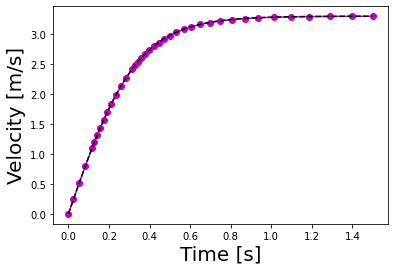

In [4]:
# Problem data
v0 = 0 #initial velocity, in m/s
rho = 1.22; #air density, in kg/m^3
k = .235; #empirical aerodynamic coefficient 
R = 1; #radius of the sphere, in meters
m = 1; #mass of the sphere, in kg
g = 9.81; #gravity, in m/s^2
alpha = k*rho*pi*R**2/m; #resulting Riccati coefficient (ODE: v' + alpha*v^2 - g = 0)

# Solver settings
T = 1.5 #Final simulation time, in seconds
h = 0.025 #Time-step size, in seconds

# Define right-hand-side function
def f(t,v):
    return  g - alpha*v**2
  
# Prescribe Butcher tableau for Heun's method (second-order)
aHeun = np.array([[0,   0],
              [1, 0]])
bHeun = np.array([0.5, .5])
cHeun = np.array([0, 1])

# Numerical solution via Heun's method with fixed and then adaptive step
tHeun, vHeun = explicitRK(aHeun, bHeun, cHeun, v0, T, f, h) 
tAdaptive, vAdaptive, hAdaptive = HeunWithEuler(v0, T, f, h, 1e-2, .9, 1.1)

# Plot numerical solution (adaptive scheme)
plt.plot(tAdaptive, vAdaptive, 'om-')

# Define the inverse hyperbolic arc-tangent function, to evaluate the exact (analytical) solution
def atanh(x):
    return  .5*np.log(np.abs((1+x)/(1-x)))

#Plot exact solution 
tFine = np.linspace(0,T,1000);
plt.plot(tFine,((g/alpha)**.5)*np.tanh(((alpha*g)**.5)*tFine + atanh(v0*(alpha/g)**.5)),'--k')

#Axis and legend for the plots
#plt.legend(['Euler', 'Heun', 'Taylor', 'Exact'], fontsize = 16)
plt.xlabel('Time [s]', fontsize = 20)
plt.ylabel('Velocity [m/s]', fontsize = 20)
plt.rcParams['figure.figsize'] = [15, 6]

#Compute and print global errors 
vExact = ((g/alpha)**.5)*np.tanh(((alpha*g)**.5)*tAdaptive + atanh(v0*(alpha/g)**.5))
ErrorAdaptiveStep = max(abs(vExact-vAdaptive))
vExact = ((g/alpha)**.5)*np.tanh(((alpha*g)**.5)*tHeun + atanh(v0*(alpha/g)**.5))
ErrorFixedStep = max(abs(vExact-vHeun))
print('Number of (adaptive) time steps =', len(tAdaptive))
print('Error with adaptive scheme =', ErrorAdaptiveStep)
print('Number of (fixed) time steps =', len(tHeun))
print('Error with non-adaptive scheme =', ErrorFixedStep)
#print('adaptive time-step sizes =',hAdaptive)